In [41]:
# Prerequisites
# ! pip install -U pandas
# ! pip install -U nltk  
# ! pip install -U gensim     
# ! pip install -U wordcloud
# ! python3 -m spacy download en_core_web_sm
# ! pip install -U pyLDAvis
# ! pip install -U keras

In [42]:
# Importing Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

#NLTK libraries
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

#vis
import pyLDAvis
import pyLDAvis.gensim_models

# Machine Learning libraries
import sklearn 
from sklearn.model_selection import train_test_split

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Deep learning libraries
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [43]:
# Loading Dataset
df=pd.read_csv('RAW_NEWS.csv')

# Temporarily using first 100 news only
# df = df[:200]
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...


# PRE-PROCESSING DATA

In [44]:
# Cleansing the News heading by removing un-nessary words
df['HeadingOfNews'] = df['HeadingOfNews'].str.replace('\+|- DAWN.COM| Newspaper', '')

# Removing "Published in Dawn" from the end off news content
df['BodyOfNews'] = df['BodyOfNews'].str.split('Published in Dawn,').str[0]

# Comibining News Heading and Body
df['originalCombined'] = df['HeadingOfNews'] + ' ' + df['BodyOfNews']
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...


In [45]:
# download stopwords
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aniqurrahman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['originalCombined']))

In [47]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [48]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    nlp = spacy.load("en_core_web_sm")
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [49]:
def preprocess(text):
    # Remove Stop Words
    data_words_nostops = remove_stopwords(text)
    # Do Lemmatization
    data_lemmatized = lemmatization(data_words_nostops)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_lemmatized)
    # Form Trigrams
    data_words_trigrams = make_trigrams(data_words_bigrams)
    
    return data_words_trigrams

In [50]:
data_preprocessed = preprocess(data_words)
df['clean'] = data_preprocessed

df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined,clean
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...,"[qaiser, rue, decision, grant, extension, bajw..."
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...,"[imran, could, opted, suicide_attack, treat, l..."
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...,"[three, police, official, martyr, nowshera, gu..."
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...,"[coal, miner, kill, gas, explosion, harnai, pa..."
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...,"[sc, throw, joint, petition, perk, kp, teacher..."


# VISUALIZE CLEANED UP DATASET

In [51]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

print("Word Count Total:", len(list_of_words))
# Obtain the total number of unique words
print("Word Count Unique:", len(list(set(list_of_words))))

Word Count Total: 627825
Word Count Unique: 27754


<AxesSubplot: xlabel='count', ylabel='Topic'>

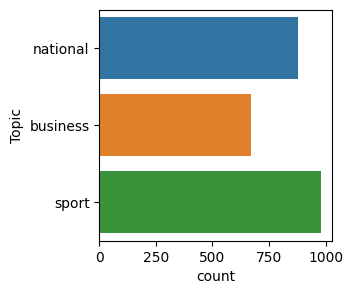

In [52]:
# plot the number of samples in 'HeadingOfNews'
plt.figure(figsize = (3, 3))
sns.countplot(y = "Topic", data = df)

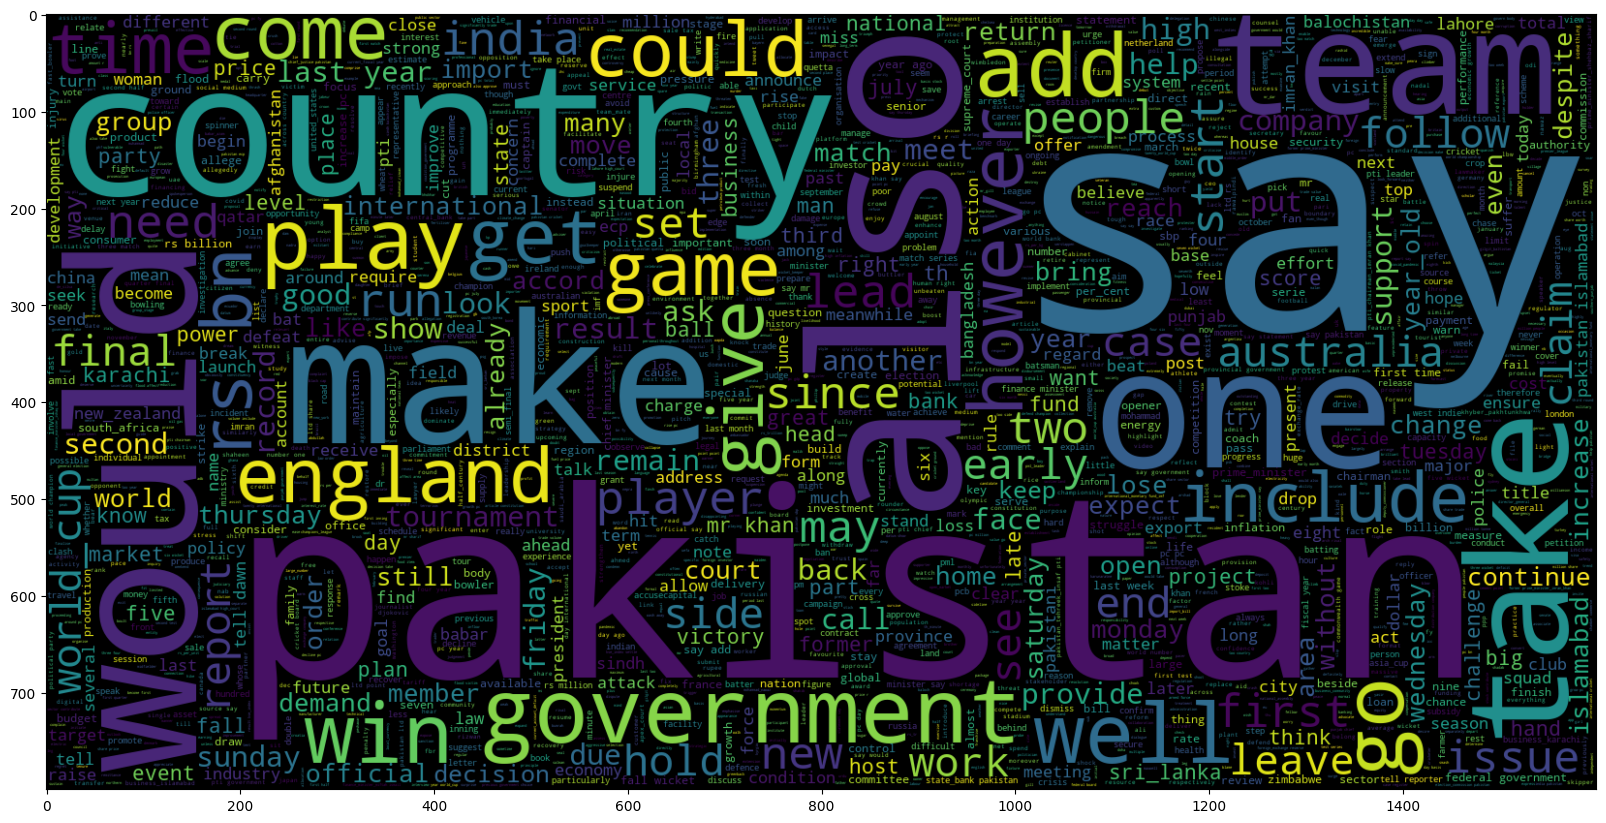

In [53]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df.clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [54]:
# length of maximum document will be needed to create word embeddings 
max_doc_len = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(max_doc_len<len(tokens)):
        max_doc_len = len(tokens)
print("The maximum number of words in any document is =", max_doc_len)

The maximum number of words in any document is = 779


# FEATURE EMBEDDING USING BAG OF WORDS

In [55]:
id2word = corpora.Dictionary(data_preprocessed)

bow_corpus = []
for text in data_preprocessed:
    new = id2word.doc2bow(text)
    bow_corpus.append(new)

# print ("BOW News1:\n",bow_corpus[0])
# firstword = id2word[[0][:1][0]]
# print (firstword)

df['BOW'] = bow_corpus

df.head()


,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined,clean,clean_joined,BOW
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...,"[qaiser, rue, decision, grant, extension, bajw...",qaiser rue decision grant extension bajwa isla...,"[(0, 4), (1, 3), (2, 1), (3, 2), (4, 1), (5, 1..."
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...,"[imran, could, opted, suicide_attack, treat, l...",imran could opted suicide_attack treat like sw...,"[(6, 1), (9, 1), (28, 2), (40, 1), (48, 1), (5..."
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...,"[three, police, official, martyr, nowshera, gu...",three police official martyr nowshera gun atta...,"[(0, 1), (6, 1), (9, 2), (12, 2), (33, 1), (46..."
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...,"[coal, miner, kill, gas, explosion, harnai, pa...",coal miner kill gas explosion harnai pakistan ...,"[(0, 2), (9, 1), (12, 1), (27, 1), (44, 1), (8..."
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...,"[sc, throw, joint, petition, perk, kp, teacher...",sc throw joint petition perk kp teacher pakist...,"[(9, 1), (27, 1), (33, 3), (40, 1), (49, 2), (..."


# LDA TOPIC MODELLING

In [56]:
TOPIC_COUNT = 3

lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=id2word,
                                           num_topics=TOPIC_COUNT,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")


In [57]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, id2word, mds="mmds", R=30)
vis


/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.094783  0.206072       1        1  35.703730
0      0.102502 -0.167329       2        1  33.983906
2     -0.197284 -0.038743       3        1  30.312364, topic_info=         Term         Freq        Total Category  logprob  loglift
810        pc  2838.000000  2838.000000  Default  30.0000  30.0000
643        rs  2417.000000  2417.000000  Default  29.0000  29.0000
876        bn  1630.000000  1630.000000  Default  28.0000  28.0000
67        pti  1785.000000  1785.000000  Default  27.0000  27.0000
781  increase  1365.000000  1365.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
196      also   899.149360  2943.201769   Topic3  -5.3550   0.0078
877    budget   542.169049   657.163746   Topic3  -5.8608   1.0013
97      would   637.686128  2158.259219   Topic3  -5.6986  -0.0256
147      last   593.618075  1961.944679   Topic3  -5.7702  -0.0018
217       day   577.645368  1916.424090   Topic3  -5.7974  -0.0056

[221 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.259456       add
0         2  0.489743       add
0         3  0.251012       add
195       2  0.998892    allege
196       1  0.217450      also
...     ...       ...       ...
99        1  0.352716      year
99        2  0.088547      year
99        3  0.558933      year
191       1  0.977100  year_old
191       2  0.023566  year_old

[313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])